In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/home/dmartins/GitWorkspace/phd-query-synthesis/PhDCoding


In [3]:
import sys, os
sys.path.append('..\\PhDCoding\\decision')
sys.path.append('..\\PhDCoding\\qbe')

In [4]:
from IPython.display import Image, HTML
from decision.somselector import SomSelector
from qbe.deapgpqbe import DEAPGeneticProgrammingQBE
from qbe.fitfunction import QueryDiscoveryFitnessFunction
from qbe.treeqbe import DecisionTreeQBE
from qbe import util
import pandas as pd, pandasql as pdsql
import re

In [5]:
def show_images(indices):
    for i in indices:
        print("ID:{} - {}".format(i, dataset.original_data.iloc[i]['make']))
        display(Image(filename=(images[i]), width=300))

In [6]:
class Dataset(object):
    def __init__(self, original_data, preprocessed_data):
        self.original_data = original_data
        self.preprocessed_data = preprocessed_data
        self.data_matrix = preprocessed_data.as_matrix()

    def get_original_indices(self, tuples):
        indices = []
        for row in tuples.values:
            for i in range(self.original_data.shape[0]):
                if (row == self.original_data[i]).all():
                    indices.append(i)

        return indices

### Loading and configuring car dataset

In [7]:
cartable = pd.read_pickle('datasets\\car_original_dataset.pkl')
cartable.columns = [str.lower(col.replace('.', '_')) for col in cartable.columns]
cartable['origin'] = cartable['origin'].map({0: False, 1: True})
cartable['automatic_gearbox'] = cartable['automatic_gearbox'].map({0: False, 1: True})

FileNotFoundError: [Errno 2] No such file or directory: 'datasets\\car_original_dataset.pkl'

In [8]:
images = ["car-images\\" + str(x) for x in cartable['imagepath']]
del cartable['imagepath']

In [9]:
cartable

,make,manufacturer,type,price,mpg,num_of_cylinders,horsepower,fuel_tank_capacity,rpm,wheelbase,rear_seat_room,weight,automatic_gearbox,passenger_capacity,length,width,luggage_capacity,airbags,drivetrain,origin
1,Acura Integra,Acura,Small,7950.0,28.0,4,140,13.2,6300,102,26.500000,2705,False,5,177,68,11.000000,None,Front,True
2,Acura Legend,Acura,Midsize,16950.0,21.5,6,200,18.0,5500,115,30.000000,3560,False,5,195,71,15.000000,DriverAndPassenger,Front,True
3,Audi 90,Audi,Compact,14550.0,23.0,6,172,16.9,5500,102,28.000000,3375,False,5,180,67,14.000000,DriverOnly,Front,True
4,Audi 100,Audi,Midsize,18850.0,22.5,6,172,21.1,5500,106,31.000000,3405,False,6,193,70,17.000000,DriverAndPassenger,Front,True
5,BMW 535i,BMW,Midsize,15000.0,26.0,4,208,21.1,5700,109,27.000000,3640,False,4,186,69,13.000000,DriverOnly,Rear,True
6,Buick Century,Buick,Midsize,7850.0,26.5,4,110,16.4,5200,105,28.000000,2880,True,6,189,69,16.000000,DriverOnly,Front,False
7,Buick LeSabre,Buick,Large,10400.0,23.5,6,170,18.0,4800,111,30.500000,3470,True,6,200,74,17.000000,DriverOnly,Front,False
8,Buick Roadmaster,Buick,Large,11850.0,20.5,6,180,23.0,4000,116,30.500000,4105,True,6,216,78,21.000000,DriverOnly,Rear,False
9,Buick Riviera,Buick,Midsize,13150.0,23.0,6,170,18.8,4800,108,26.500000,3495,True,5,198,73,14.000000,DriverOnly,Front,False
10,Cadillac DeVille,Cadillac,Large,17350.0,20.5,8,200,18.0,4100,114,35.000000,3620,True,6,206,73,18.000000,DriverOnly,Front,False


In [10]:
preprocessed_data = pd.read_pickle('datasets\\dummy_cartable.pkl')

In [11]:
dataset = Dataset(cartable, preprocessed_data)

C:\Users\d_mart04\Python\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


### Configure PandaSQL to query Pandas dataframe

In [12]:
pysql = lambda q: pdsql.sqldf(q, globals())

### Input Example
##### NOTE: Typos in examples provoke a fail in learning a query

In [13]:
example = pd.DataFrame(data=[
        ['chevrolet camaro', 7550.0, False], 
        ['Mustang', 7950.0, False],
        ['Firebird', 8850.0, False]], 
        columns=['model', 'price', 'automatic_gear'])

example['model'] = example['model'].astype('str')
example['price'] = example['price'].astype('float')
example['automatic_gear'] = example['automatic_gear'].astype('bool')
example

,model,price,automatic_gear
0,chevrolet camaro,7550.0,False
1,Mustang,7950.0,False
2,Firebird,8850.0,False


##### Use the following code for lazy example acquisition:

### Finding Project Predicates

In [14]:
def get_global_inverted_index(table, tablename='foo'):
    inverted_index = []
    for col in table.columns:
        for val in set(table[col].values):
            inverted_index.append([val, type(val), col, 'cartable'])
    return pd.DataFrame(data=inverted_index, columns=['Value', 'Type', 'Name', 'Table'])

In [15]:
%time inverted_index = get_global_inverted_index(cartable, 'cartable')

Wall time: 1.99 ms


In [16]:
def get_project_columns_and_tables(inverted_index):
    columns_to_project = []
    tables_to_project = set()
    for attribute_example in [example[col][0] for col in example.columns]:
        selected_rows = inverted_index.loc[inverted_index['Type'] == type(attribute_example)]
        for index, row in selected_rows.iterrows():
            if type(attribute_example) is str:
                if str.lower(attribute_example) in str.lower(row['Value']):
                    tables_to_project.add(row['Table'])
                    columns_to_project.append(str.format('{0}.{1}', row['Table'], row['Name']))
            elif attribute_example == row['Value']:
                tables_to_project.add(row['Table'])
                columns_to_project.append(str.format('{0}.{1}', row['Table'], row['Name']))
    return columns_to_project, tables_to_project

In [17]:
%time columns_to_project, tables_to_project = get_project_columns_and_tables(inverted_index)

Wall time: 40.9 ms


#### Presenting project query to the user

In [18]:
def get_projection_query_part(tables_to_project, columns_to_project):
    return 'SELECT ' + ', '.join(columns_to_project) + ' FROM ' + ', '.join(tables_to_project)

In [19]:
projection_query_part = get_projection_query_part(tables_to_project, columns_to_project)
projection_query_part

'SELECT cartable.make, cartable.price, cartable.automatic_gearbox, cartable.origin FROM cartable'

#### Ask user for feedback on projection columns and tables. User can add/remove columns or change the order - TODO: Automatize it.

In [20]:
projection_query_part_after_feedback = 'SELECT cartable.make, cartable.price, cartable.automatic_gearbox FROM cartable'
projection_query_part_after_feedback

'SELECT cartable.make, cartable.price, cartable.automatic_gearbox FROM cartable'

### Finding selection predicates
##### The search space is composed by all tuples returned by joining the identified tables needed to produce the user example. If the database is composed by only one table, the search space is composed by all tuples in the table.
##### Positive tuples: All tuples containing the user example. Negative tuples: All remaining tuples.

In [21]:
resulting_tuples = pysql(projection_query_part_after_feedback)

In [22]:
def get_positive_and_negative_indices(resulting_tuples, example):
    positive_tuples_indices = set()
    negative_tuples_indices = set()

    for ex in example.values:
        for i in range(resulting_tuples.shape[0]):
            matched = []
            for j in range(resulting_tuples.shape[1]):
                if type(ex[j]) is str and str.lower(ex[j]) in str.lower(resulting_tuples.values[i][j]):
                    matched.append(True) 
                elif ex[j] == resulting_tuples.values[i][j]:
                    matched.append(True) 
                else:
                    matched.append(False)
            if False in matched:
                negative_tuples_indices.add(i)
            else:
                positive_tuples_indices.add(i)
                
    return positive_tuples_indices, negative_tuples_indices

In [23]:
%time  positive_tuples_indices, negative_tuples_indices = get_positive_and_negative_indices(resulting_tuples, example)

Wall time: 62.8 ms


ID:33 - Ford Mustang


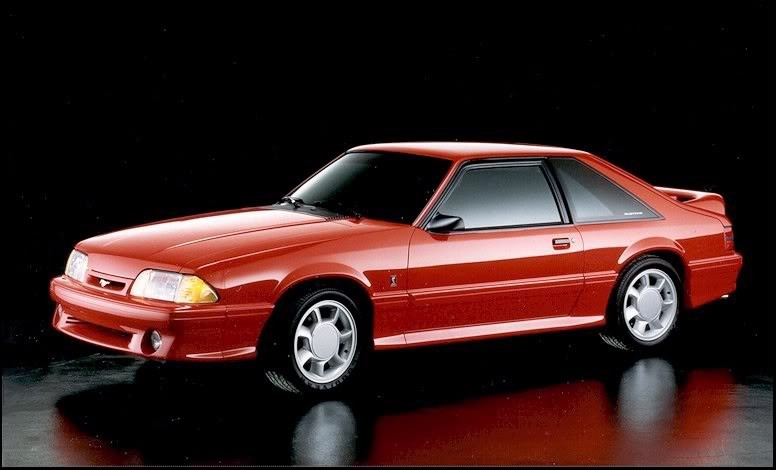

ID:74 - Pontiac Firebird


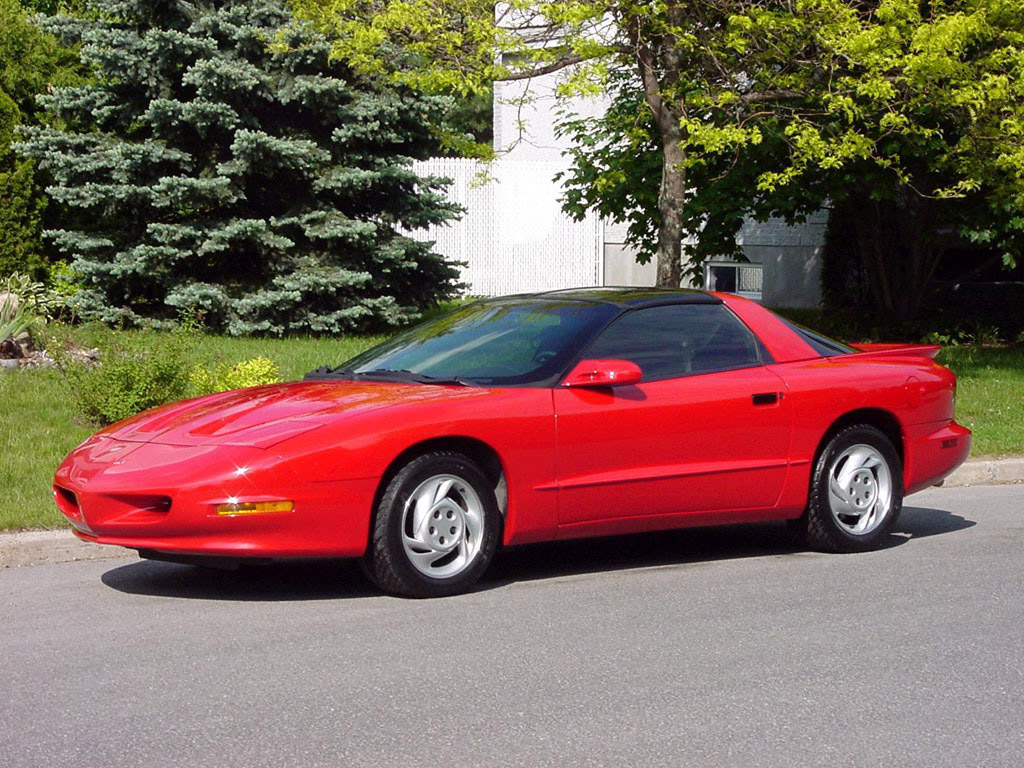

ID:13 - Chevrolet Camaro


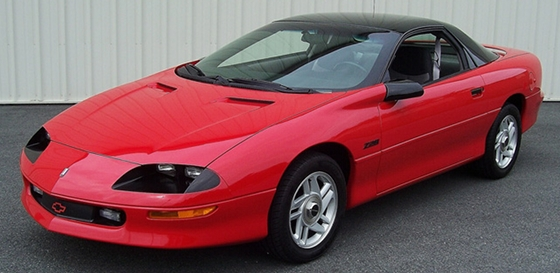

In [24]:
show_images(positive_tuples_indices)

#### Using SOM to find semantic-related examples

In [25]:
som_selector = SomSelector(som_size=(10,10), num_iterations=2000, learning_rate=0.1, sigma=1.0)

In [26]:
def get_semantic_related_example_indices(som_selector, dataset, positive_indices):
    selected_indices = []
    for posidx in positive_indices:
        selected_indices.extend(som_selector.select(query=dataset.data_matrix[posidx], dataset=dataset, num_selected_items=3))
    return list(set(selected_indices))

In [27]:
%time semantic_related_indices = get_semantic_related_example_indices(som_selector, dataset, positive_tuples_indices)

Wall time: 518 ms


ID:33 - Ford Mustang


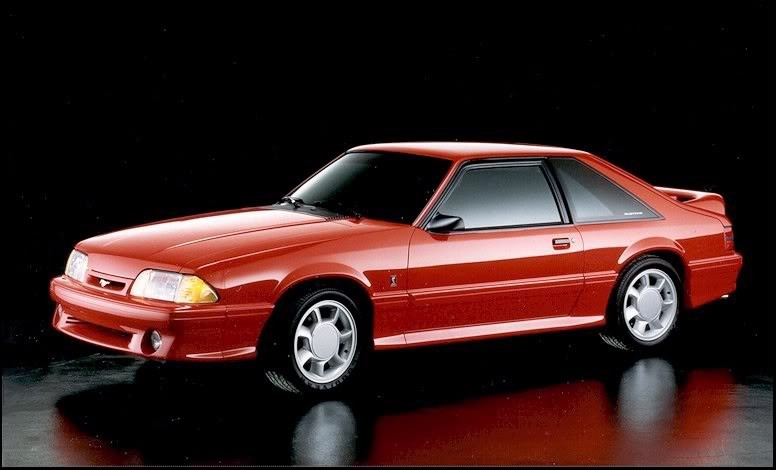

ID:34 - Ford Probe


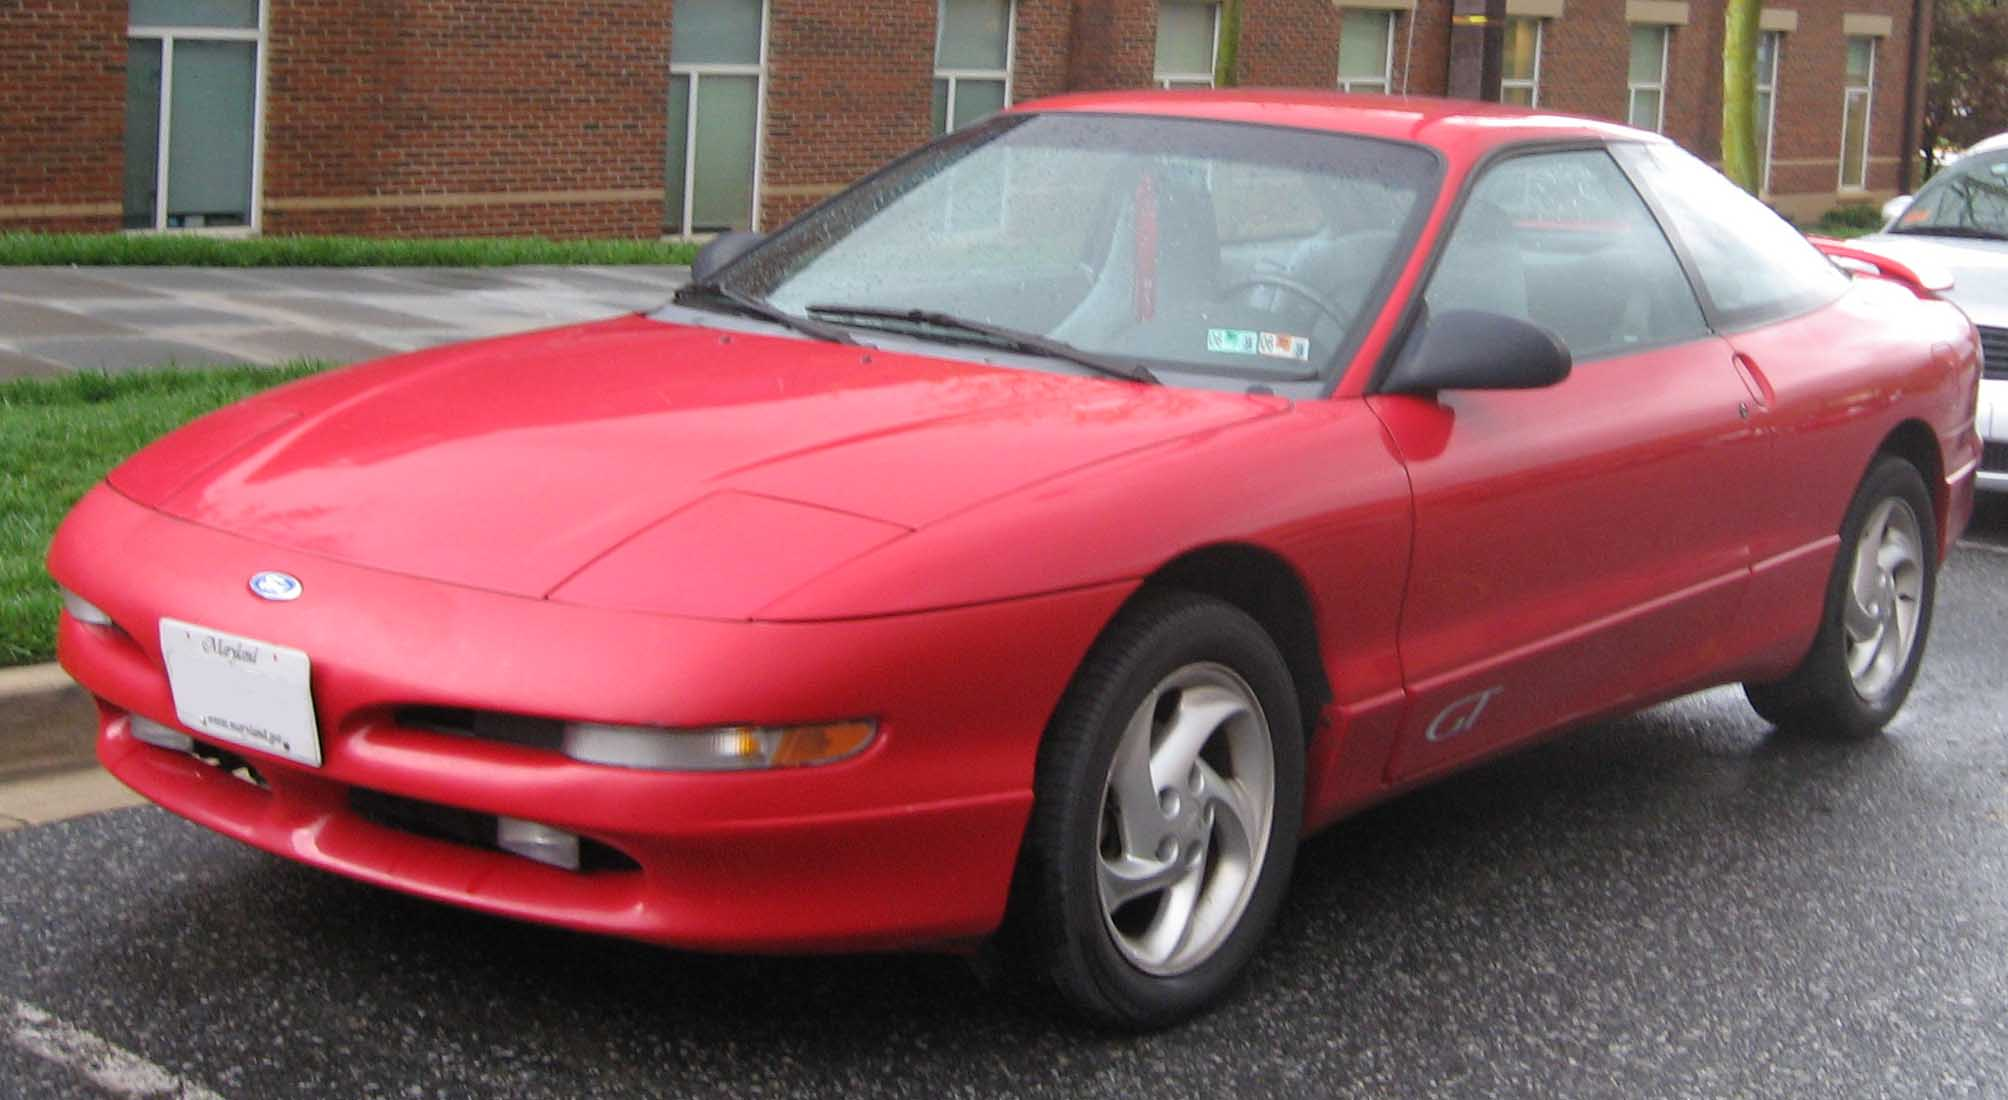

ID:35 - Ford Aerostar


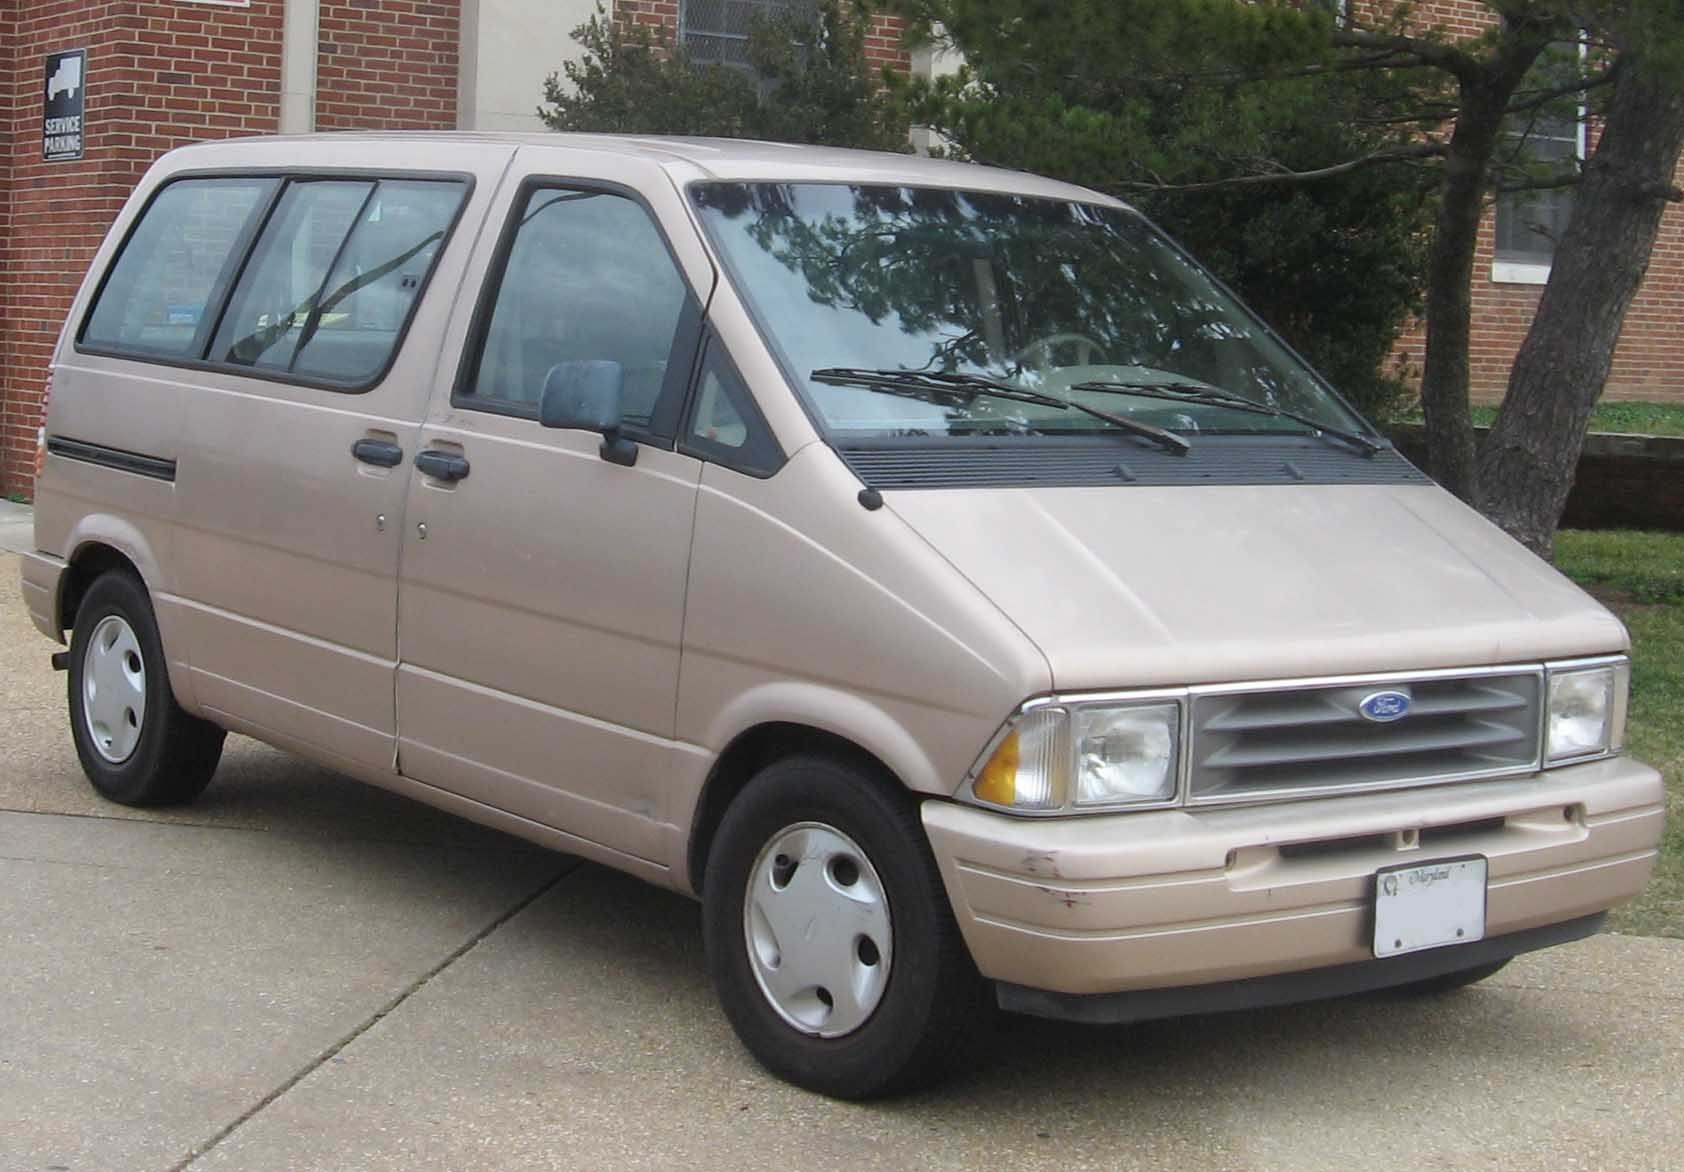

ID:74 - Pontiac Firebird


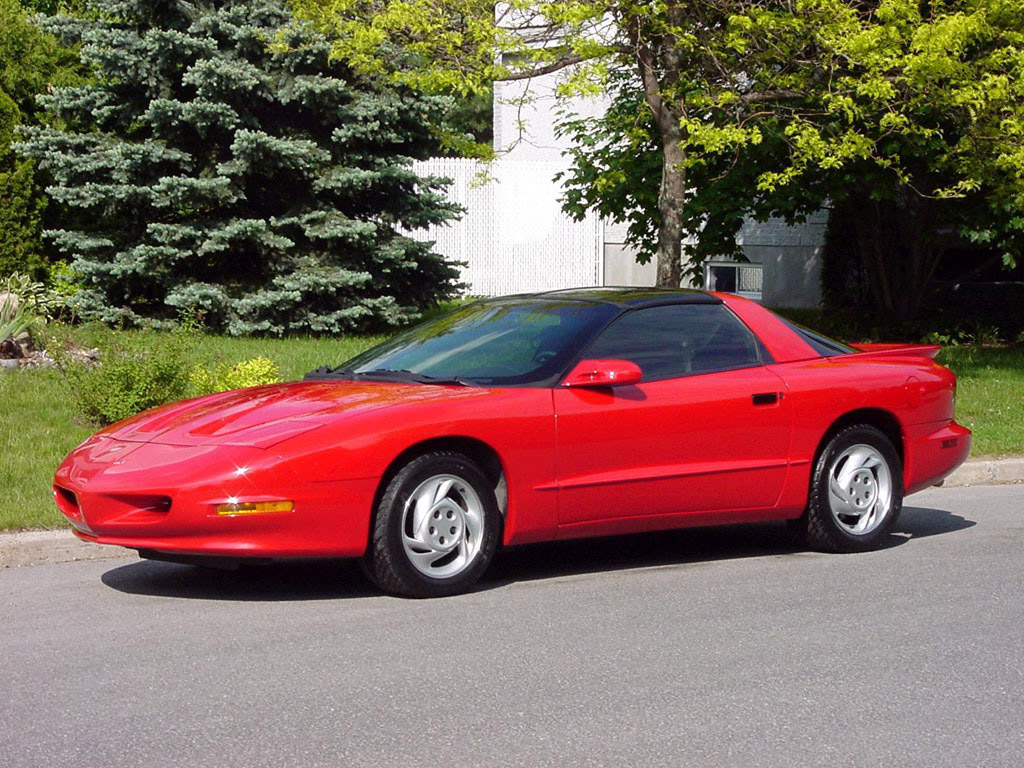

ID:13 - Chevrolet Camaro


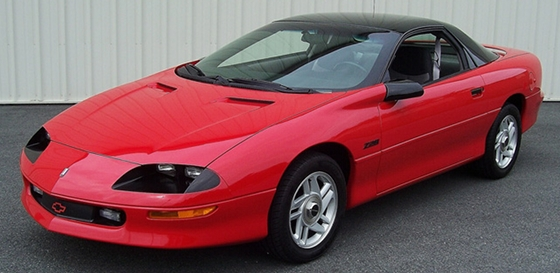

ID:18 - Chevrolet Corvette


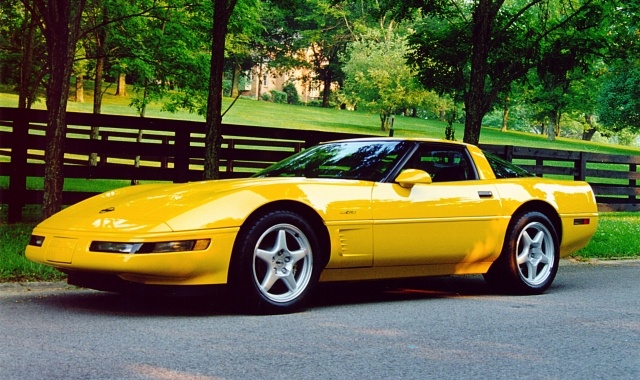

In [28]:
show_images(semantic_related_indices)

#### Asking user to adjust selected tuples
##### If semantic-related tuples are desired, use: positive_indices = semantic_related_indices; Otherwise: positive_indices = positive_tuples_indices

In [29]:
positive_indices = semantic_related_indices #[idx for idx in semantic_related_indices if not idx in [12, 40]]

#### Using a Decision Tree to find the selection predicates

In [30]:
decision_tree = DecisionTreeQBE(dataset.preprocessed_data, positive_indices)

In [31]:
%time best_predicate = decision_tree.search_best_predicate()

Wall time: 11 ms


In [32]:
best_predicate

'type##Sporty## > 0.5 AND width > 0.9358974397182465 OR type##Sporty## > 0.5 AND width <= 0.9358974397182465 AND manufacturer##Ford## > 0.5 OR type##Sporty## <= 0.5 AND mpg <= 0.3802083432674408 AND weight <= 0.9451887905597687'

#### Converting predicate to original data

In [33]:
# Only works when enconded variables are binary
def preprocessed_predicate_to_original(predicate, cartable):
    original_predicate = predicate
    extracted_preds = []
    for and_pred in predicate.split('AND'):
        if 'OR' in and_pred:
            for or_pred in and_pred.split('OR'):
                extracted_preds.append(or_pred.strip())
        else:
            extracted_preds.append(and_pred.strip())

    for pred in extracted_preds:
        if '##' in pred:
            for col in cartable.columns:
                if col in pred:
                    encoded = re.split(r"##", pred)
                    equal = False
                    for op in ['>', '>=']:
                        if op in encoded[2]:
                            equal = True
                            break
                    if equal:
                        new_pred = str.format('{0} == \'{1}\'', encoded[0], encoded[1])
                    else:
                        new_pred = str.format('{0} <> \'{1}\'', encoded[0], encoded[1])
                    original_predicate = original_predicate.replace(pred, new_pred)
    
    return original_predicate

In [34]:
selection_predicate = preprocessed_predicate_to_original(best_predicate, cartable)

#### Evaluating predicate quality

In [35]:
output_view = pysql('SELECT * FROM cartable WHERE ' + selection_predicate)
util.get_information_retrieval_metrics(dataset.original_data, dataset.original_data.iloc[list(positive_indices)], output_view)

Relevant & Actual:  5
Recall:  0.8333333333333334
Specificity:  0.896551724137931
Precision:  0.35714285714285715
F1-Score:  0.5
False negative rate:  0.16666666666666663
False positive rate:  0.10344827586206895


(0.8333333333333334, 0.896551724137931, 0.35714285714285715, 0.5)

### Producing query

In [36]:
produced_query = projection_query_part_after_feedback + ' WHERE ' + selection_predicate
produced_query

"SELECT cartable.make, cartable.price, cartable.automatic_gearbox FROM cartable WHERE type == 'Sporty' AND width > 0.9358974397182465 OR type == 'Sporty' AND width <= 0.9358974397182465 AND manufacturer == 'Ford' OR type <> 'Sporty' AND mpg <= 0.3802083432674408 AND weight <= 0.9451887905597687"

### Visualizing results

In [37]:
produced_view = pysql(produced_query)
produced_view

,make,price,automatic_gearbox
0,Chevrolet Camaro,7550.0,0
1,Chevrolet Corvette,19000.0,0
2,Dodge Stealth,12900.0,0
3,Ford Mustang,7950.0,0
4,Ford Probe,7000.0,0
5,Geo Storm,6250.0,0
6,Honda Prelude,9900.0,0
7,Hyundai Scoupe,5000.0,0
8,Mazda RX-7,16250.0,0
9,Mercury Capri,7050.0,0


### Playground

In [50]:
class Preference(object):
    def __init__(self, tablename, column, operator, value):
        self.tablename = tablename
        self.column = column
        self.operator = operator
        self.value = value
        
    def __str__(self):
        return str.format('{{0}\[{1}\]} {2} {3}', self.tablename, self.column, self.operator, self.value)
    
    def use(self):
        return str.format('{0} {1} {2}', self.column, self.operator, self.value)
        

In [51]:
my_preference = Preference('cartable', 'price', '<=', example['price'].median())

In [52]:
query = str.format('{0} AND {1}', produced_query, my_preference.use())
view = pysql(query)
view

,make,price,automatic_gearbox
0,Acura Integra,7950.0,0
1,Acura Legend,16950.0,0
2,Audi 90,14550.0,0
3,Audi 100,18850.0,0
4,BMW 535i,15000.0,0
5,Buick Century,7850.0,1
6,Buick LeSabre,10400.0,1
7,Buick Roadmaster,11850.0,1
8,Buick Riviera,13150.0,1
9,Cadillac DeVille,17350.0,1


In [53]:
util.get_information_retrieval_metrics(dataset.original_data, dataset.original_data.iloc[list(positive_indices)], view)

Relevant & Actual:  0
Recall:  0.0
Specificity:  1.0
Precision:  0.0
F1-Score:  0
False negative rate:  1.0
False positive rate:  0.0


(0.0, 1.0, 0.0, 0)

In [54]:
american_sportive_cars = pysql("SELECT * FROM cartable WHERE origin = 0 AND type = 'Sporty'")
american_sportive_cars

,make,manufacturer,type,price,mpg,num_of_cylinders,horsepower,fuel_tank_capacity,rpm,wheelbase,rear_seat_room,weight,automatic_gearbox,passenger_capacity,length,width,luggage_capacity,airbags,drivetrain,origin
0,Chevrolet Camaro,Chevrolet,Sporty,7550.0,23.5,6,160,15.5,4600,101,25.000000,3240,0,4,193,74,13.000000,DriverAndPassenger,Rear,0
1,Chevrolet Corvette,Chevrolet,Sporty,19000.0,21.0,8,300,20.0,5000,96,30.901059,3380,0,2,179,74,17.203669,DriverOnly,Rear,0
2,Dodge Stealth,Dodge,Sporty,12900.0,21.0,6,300,19.8,6000,97,20.000000,3805,0,4,180,72,11.000000,DriverOnly,4WD,0
3,Ford Mustang,Ford,Sporty,7950.0,25.5,4,105,15.4,4600,101,24.000000,2850,0,4,180,68,12.000000,DriverOnly,Rear,0
4,Ford Probe,Ford,Sporty,7000.0,27.0,4,115,15.5,5500,103,23.000000,2710,0,4,179,70,18.000000,DriverOnly,Front,0
5,Mercury Capri,Mercury,Sporty,7050.0,24.5,4,100,11.1,5750,95,19.000000,2450,0,4,166,65,6.000000,DriverOnly,Front,0
6,Plymouth Laser,Plymouth,Sporty,7200.0,26.5,4,92,15.9,5000,97,24.500000,2640,0,4,173,67,8.000000,None,4WD,0
7,Pontiac Firebird,Pontiac,Sporty,8850.0,23.5,6,160,15.5,4600,101,25.000000,3240,0,4,196,75,13.000000,DriverAndPassenger,Rear,0
